# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [85]:
import pickle

training_file = 'data/train.p'
validation_file = 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_in, y_train = train['features'], train['labels']
X_valid_in, y_valid = valid['features'], valid['labels']
X_test_in, y_test = test['features'], test['labels']

In [86]:
import pandas as pd

signnames = pd.read_csv('signnames.csv')

---

## Step 1: Dataset Summary & Exploration

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [87]:
n_train = X_train_in.shape[0]
n_valid = X_valid_in.shape[0]
n_test = X_test_in.shape[0]
image_shape = X_train_in.shape[1:]
n_classes = len(signnames)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

In [88]:
import matplotlib.pyplot as plt
%matplotlib inline

In [89]:
import numpy as np

def visualize(X, y):
    for label in range(n_classes):
        name = signnames.loc[label][1]
        indices = np.argwhere(y==label).reshape(-1)
        total = len(indices)
        if not total:
            continue
        print('{:02d} — {} — {} image(s)'.format(label, name, total))
        samples = np.random.choice(indices, min(10, total))
        f, ax = plt.subplots(1, len(samples), sharex=True, sharey=True,
                             squeeze=False, figsize=(len(samples), 1))
        for i in range(len(samples)):
            ax[0][i].imshow(X[samples[i]])
        plt.xticks([])
        plt.yticks([])
        plt.show()

00 — Speed limit (20km/h) — 180 image(s)


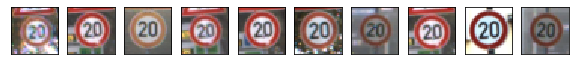

01 — Speed limit (30km/h) — 1980 image(s)


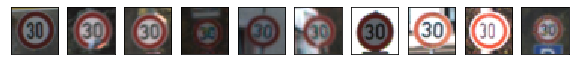

02 — Speed limit (50km/h) — 2010 image(s)


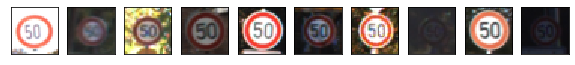

03 — Speed limit (60km/h) — 1260 image(s)


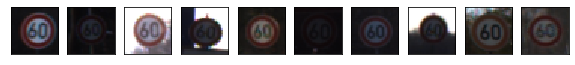

04 — Speed limit (70km/h) — 1770 image(s)


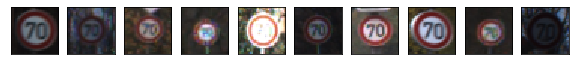

05 — Speed limit (80km/h) — 1650 image(s)


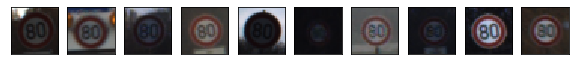

06 — End of speed limit (80km/h) — 360 image(s)


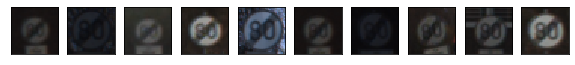

07 — Speed limit (100km/h) — 1290 image(s)


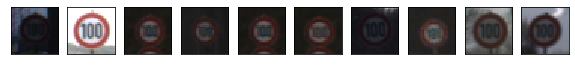

08 — Speed limit (120km/h) — 1260 image(s)


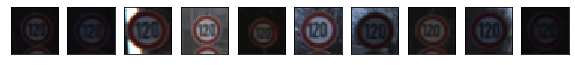

09 — No passing — 1320 image(s)


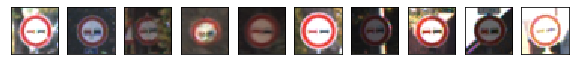

10 — No passing for vehicles over 3.5 metric tons — 1800 image(s)


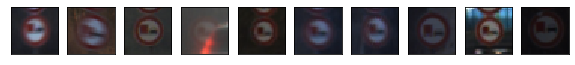

11 — Right-of-way at the next intersection — 1170 image(s)


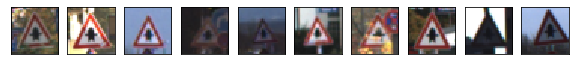

12 — Priority road — 1890 image(s)


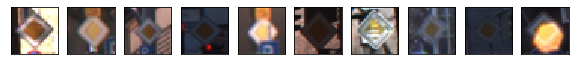

13 — Yield — 1920 image(s)


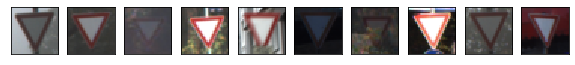

14 — Stop — 690 image(s)


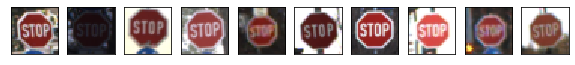

15 — No vehicles — 540 image(s)


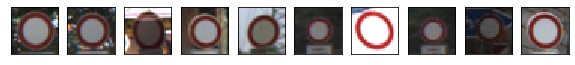

16 — Vehicles over 3.5 metric tons prohibited — 360 image(s)


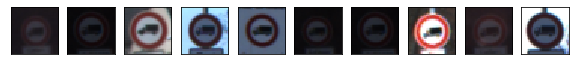

17 — No entry — 990 image(s)


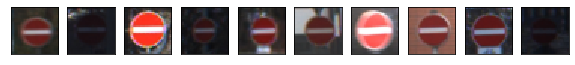

18 — General caution — 1080 image(s)


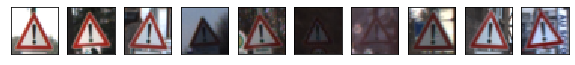

19 — Dangerous curve to the left — 180 image(s)


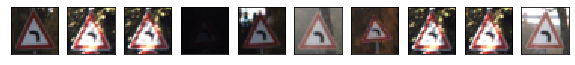

20 — Dangerous curve to the right — 300 image(s)


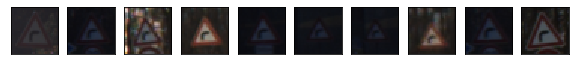

21 — Double curve — 270 image(s)


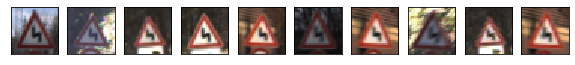

22 — Bumpy road — 330 image(s)


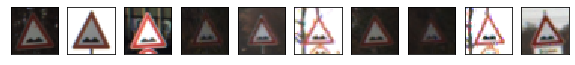

23 — Slippery road — 450 image(s)


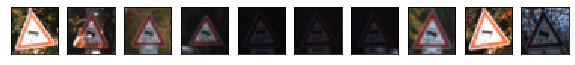

24 — Road narrows on the right — 240 image(s)


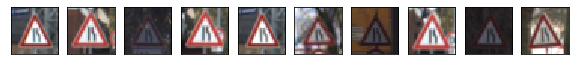

25 — Road work — 1350 image(s)


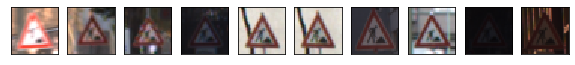

26 — Traffic signals — 540 image(s)


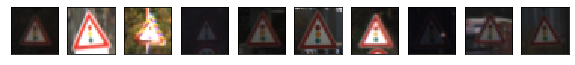

27 — Pedestrians — 210 image(s)


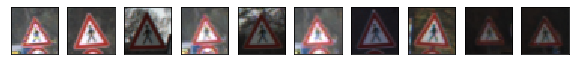

28 — Children crossing — 480 image(s)


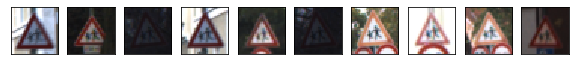

29 — Bicycles crossing — 240 image(s)


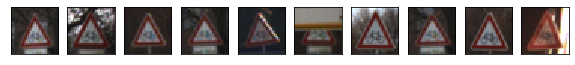

30 — Beware of ice/snow — 390 image(s)


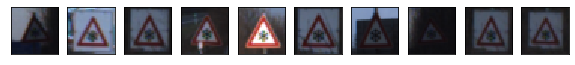

31 — Wild animals crossing — 690 image(s)


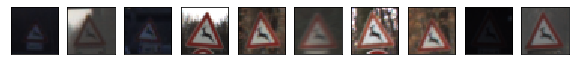

32 — End of all speed and passing limits — 210 image(s)


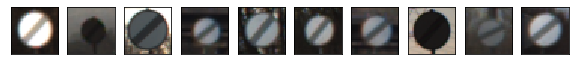

33 — Turn right ahead — 599 image(s)


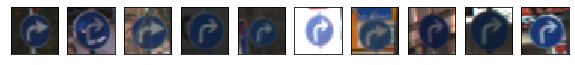

34 — Turn left ahead — 360 image(s)


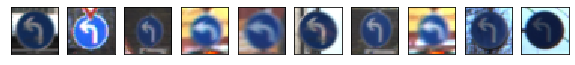

35 — Ahead only — 1080 image(s)


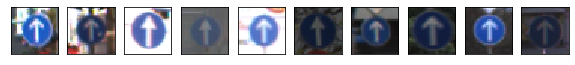

36 — Go straight or right — 330 image(s)


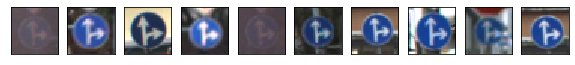

37 — Go straight or left — 180 image(s)


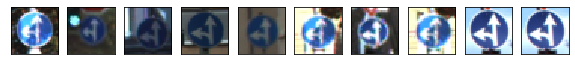

38 — Keep right — 1860 image(s)


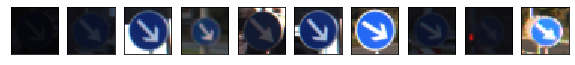

39 — Keep left — 270 image(s)


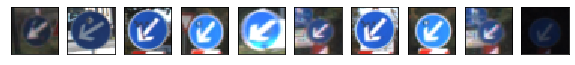

40 — Roundabout mandatory — 300 image(s)


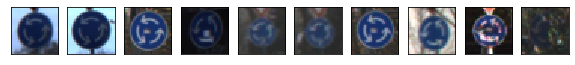

41 — End of no passing — 210 image(s)


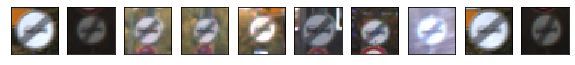

42 — End of no passing by vehicles over 3.5 metric tons — 210 image(s)


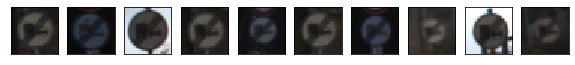

In [90]:
visualize(X_train_in, y_train)

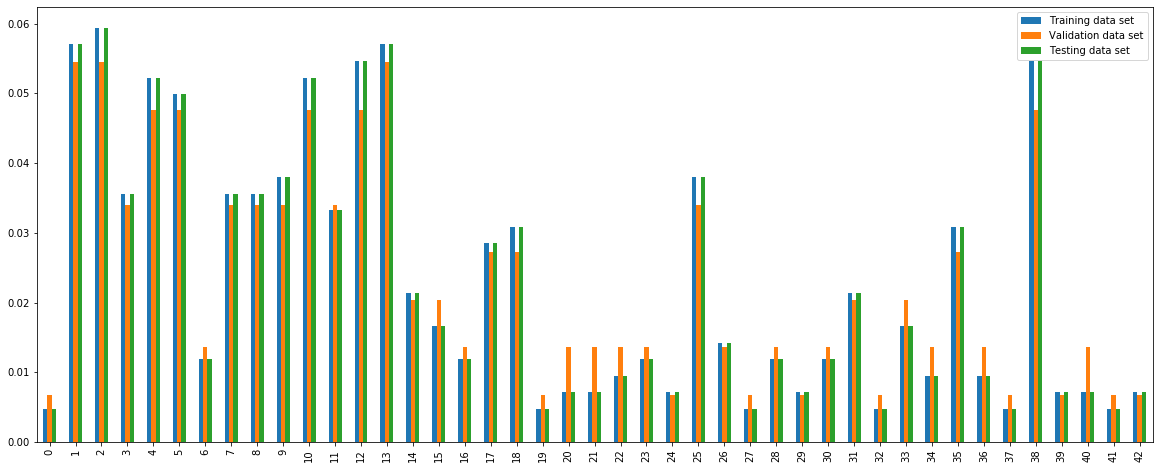

In [91]:
def calc_freq(y):
    counts = dict(zip(*np.unique(y, return_counts=True)))
    hist = [counts.get(i, 0)/len(y) for i in range(n_classes)]
    return pd.Series(hist)

df = pd.DataFrame({'Training data set': calc_freq(y_test),
                   'Validation data set': calc_freq(y_valid),
                   'Testing data set': calc_freq(y_test)})
df.plot(kind='bar', figsize=(20, 8))
plt.show()

----

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)

In [93]:
import numpy as np
import tensorflow as tf

def preprocess_input(X):
    # Normalize to [0, 1]
    X = X / 255
    
    # Convert to YUV
    X = tf.image.rgb_to_yuv(X)
    
    # Normalize to zero mean and unit variance
    X = tf.image.per_image_standardization(X)
    
    # Extract Y channel
    X = X[:, :, :, 0].eval()
    X = X.reshape(X.shape + (1,))
    return X

with tf.Session() as sess:
    X_train = preprocess_input(X_train_in)
    X_valid = preprocess_input(X_valid_in)
    X_test = preprocess_input(X_test_in)

### Model Architecture

In [94]:
print(tf.__version__)

1.14.0


In [136]:
def build_model():
    inputs = tf.keras.Input(shape=X_train.shape[1:], name='input')
    
    # Convolutional 1
    x = tf.keras.layers.Conv2D(16, 5, padding='valid', name='conv1')(inputs)
    x = tf.keras.layers.ReLU(name='conv1_relu')(x)
    x = pool1 = tf.keras.layers.MaxPool2D(2, padding='same', name='conv1_pool')(x)
    x = tf.keras.layers.Dropout(rate=0.1, name='conv1_dropout')(x)

    # Convolutional 2
    x = tf.keras.layers.Conv2D(32, 5, padding='valid', name='conv2')(x)
    x = tf.keras.layers.ReLU(name='conv2_relu')(x)
    x = pool2 = tf.keras.layers.MaxPool2D(2, padding='same', name='conv2_pool')(x)
    x = tf.keras.layers.Dropout(rate=0.2, name='conv2_dropout')(x)
    
    # Convolutional 3
    x = tf.keras.layers.Conv2D(64, 5, padding='valid', name='conv3')(x)
    x = tf.keras.layers.ReLU(name='conv3_relu')(x)
    x = pool3 = tf.keras.layers.MaxPool2D(2, padding='same', name='conv3_pool')(x)
    x = tf.keras.layers.Dropout(rate=0.3, name='conv3_dropout')(x)
    
    branch1 = tf.keras.layers.MaxPool2D(4, padding='same', name='conv1_pool2')(pool1)
    branch1 = tf.keras.layers.Flatten(name='branch1')(branch1)
    branch2 = tf.keras.layers.MaxPool2D(2, padding='same', name='conv2_pool2')(pool2)
    branch2 = tf.keras.layers.Flatten(name='branch2')(branch2)
    branch3 = tf.keras.layers.Flatten(name='branch3')(pool3)
    
    x = tf.keras.layers.concatenate([branch1, branch2, branch3], name='concat')
    
    # Fully connected 1
    x = tf.keras.layers.Dense(500, name='fc1')(x)
    x = tf.keras.layers.ReLU(name='fc1_relu')(x)
    x = tf.keras.layers.Dropout(rate=0.5, name='fc1_dropout')(x)

    # Fully connected 2
    x = tf.keras.layers.Dense(n_classes, name='fc2', activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

In [141]:
model = build_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 28, 28, 16)   416         input[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 28, 28, 16)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv1_pool (MaxPooling2D)       (None, 14, 14, 16)   0           conv1_relu[0][0]                 
____________________________________________________________________________________________

### Train, Validate and Test the Model

In [142]:
model.fit(X_train, y_train, batch_size=64, epochs=42,
          validation_data=(X_valid, y_valid))

Train on 34799 samples, validate on 4410 samples
Epoch 1/42
34799/34799 [==============================] - 14s 411us/sample - loss: 1.0140 - acc: 0.7157 - val_loss: 0.3521 - val_acc: 0.8927
Epoch 2/42
34799/34799 [==============================] - 3s 84us/sample - loss: 0.1791 - acc: 0.9462 - val_loss: 0.1954 - val_acc: 0.9390
Epoch 3/42
34799/34799 [==============================] - 3s 85us/sample - loss: 0.1073 - acc: 0.9677 - val_loss: 0.1628 - val_acc: 0.9544
Epoch 4/42
34799/34799 [==============================] - 3s 92us/sample - loss: 0.0761 - acc: 0.9770 - val_loss: 0.1824 - val_acc: 0.9528
Epoch 5/42
34799/34799 [==============================] - 3s 84us/sample - loss: 0.0632 - acc: 0.9810 - val_loss: 0.1987 - val_acc: 0.9503
Epoch 6/42
34799/34799 [==============================] - 3s 84us/sample - loss: 0.0522 - acc: 0.9833 - val_loss: 0.1434 - val_acc: 0.9612
Epoch 7/42
34799/34799 [==============================] - 3s 85us/sample - loss: 0.0500 - acc: 0.9841 - val_loss: 0

In [143]:
model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

12630/12630 [==============================] - 0s 31us/sample - loss: 0.4611 - acc: 0.9552


[0.46105985340161004, 0.95518607]

In [144]:
model.save('model.h5')

---

## Step 3: Test a Model on New Images


### Load and Output the Images

In [145]:
import os

from tensorflow.keras.preprocessing.image import img_to_array, load_img

X_new_in = []
ground_truth = []

image_dir = 'new_data'
for filename in os.listdir(image_dir):
    path = os.path.join(image_dir, filename)
    img = img_to_array(load_img(path, target_size=(32, 32)))
    label = int(os.path.splitext(filename)[0].split('_')[0])
    X_new_in.append(img)
    ground_truth.append(label)
    
X_new_in = np.array(X_new_in, dtype=np.uint8)
ground_truth = np.array(ground_truth)

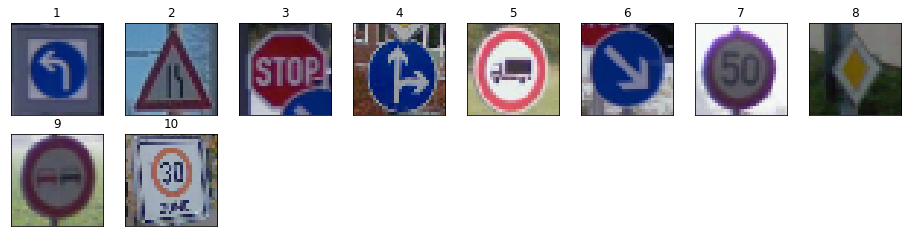

In [146]:
nrows, ncols = 8, 8
fig = plt.figure(figsize=(16, 16))
for i, img in enumerate(X_new_in):
    ax = fig.add_subplot(nrows, ncols, i+1)
    ax.set_title(str(i+1))
    plt.xticks([])
    plt.yticks([])
    ax.imshow(img)
plt.savefig('new_signs.png', bbox_inches='tight', dpi=150)
plt.show()

### Predict the Sign Type for Each Image

In [147]:
# Apply pre-processing pipeline to the new images
with tf.Session() as sess:
    X_new = preprocess_input(X_new_in)

In [148]:
y_prob = model.predict(X_new)
results = y_prob.argmax(axis=-1)

In [149]:
pd.DataFrame({
    'Image': map(lambda i: signnames.iloc[i, 1], ground_truth),
    'Prediction': map(lambda i: signnames.iloc[i, 1], results)
}, index=pd.RangeIndex(1, len(results)+1))

,Image,Prediction
1,Turn left ahead,Turn left ahead
2,Road narrows on the right,Road narrows on the right
3,Stop,Stop
4,Go straight or right,Go straight or right
5,Vehicles over 3.5 metric tons prohibited,Vehicles over 3.5 metric tons prohibited
6,Keep right,Keep right
7,Speed limit (50km/h),Speed limit (50km/h)
8,Priority road,Priority road
9,No passing,No passing
10,Speed limit (30km/h),Speed limit (30km/h)


### Analyze Performance

In [150]:
score = (results == ground_truth).sum()
accuracy = score / len(ground_truth)
print('Accuracy: {:.2f} %'.format(accuracy * 100))

Accuracy: 100.00 %


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [151]:
with tf.Session() as sess:
    top_k = sess.run(tf.nn.top_k(tf.constant(y_prob), k=5))

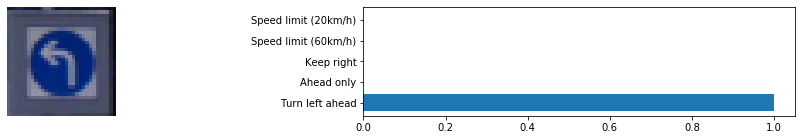

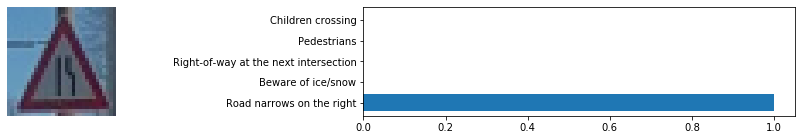

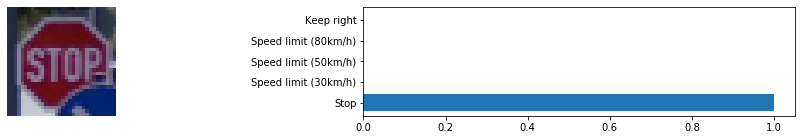

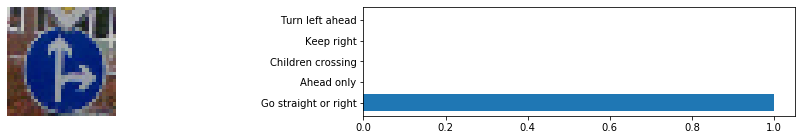

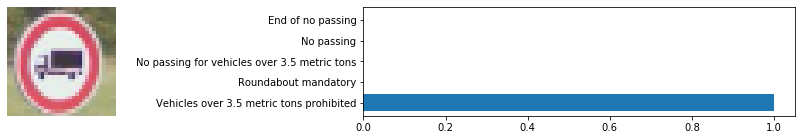

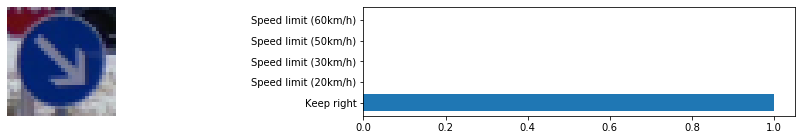

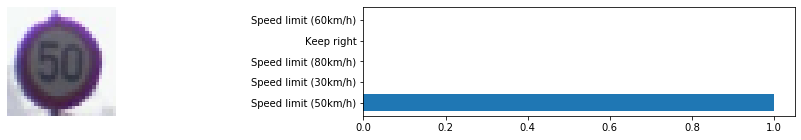

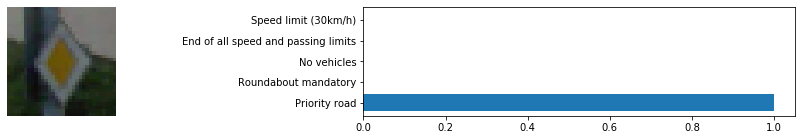

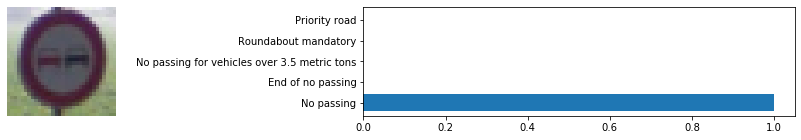

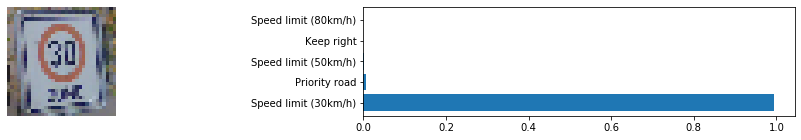

In [169]:
k = top_k.values.shape[1]
for i in range(top_k.values.shape[0]):   
    f, ax = plt.subplots(1, 2, figsize=(17, 2))
    signs = signnames.iloc[top_k.indices[i], 1]
    values = top_k.values[i]
    ax[0].imshow(X_new_in[i])
    ax[0].axis('off')
    ax[1].barh(np.arange(k), values, tick_label=signs)
    plt.show()

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images


In [153]:
def output_feature_map(X, layer_name):
    assert X.shape[-1] == 1
    feature_model = tf.keras.Model(inputs=model.input,
                                   outputs=model.get_layer(layer_name).output)
    activation = feature_model.predict(X)
    n_filters = activation.shape[3]
    
    nrows, ncols = 22, 6
    fig = plt.figure(figsize=(12, 55))
    
    ax = fig.add_subplot(nrows, ncols, 1)
    ax.set_title('Image')
    ax.imshow(X[0, :, :, 0], interpolation='nearest', cmap='gray')
    
    for i in range(n_filters):
        data = activation[0, :, :, i]
        ax = fig.add_subplot(nrows, ncols, i+2)
        ax.set_title('Filter '+str(i))
        ax.imshow(data, interpolation='nearest', cmap='gray')
        
    print(layer_name+':')
    plt.show()

conv1_relu:


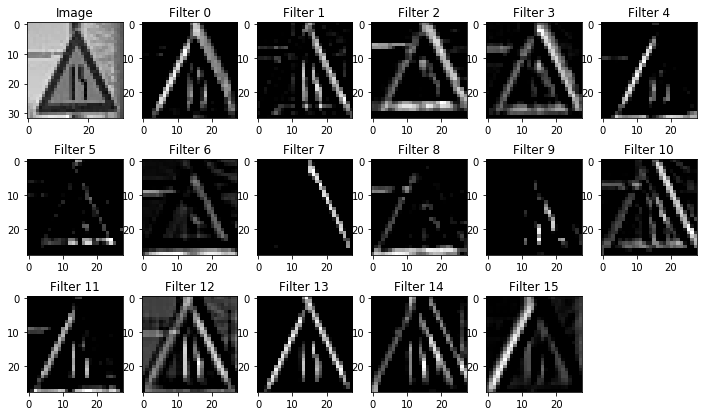

conv1_pool:


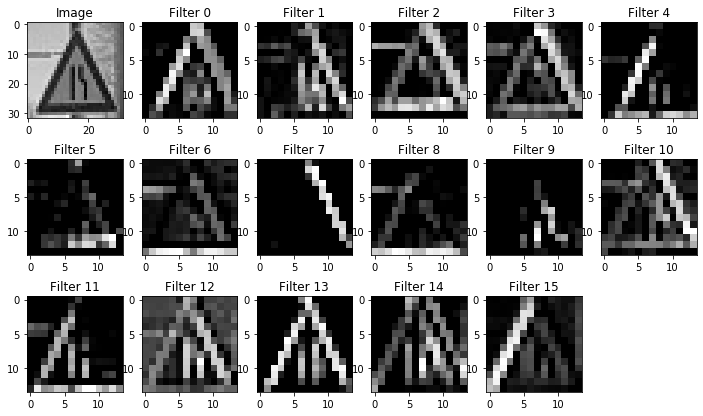

conv2_relu:


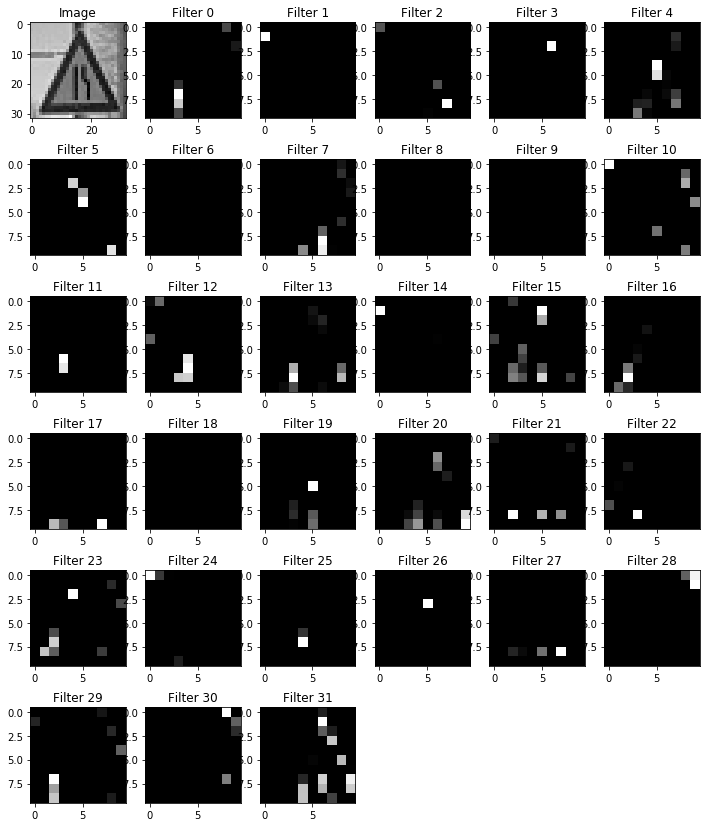

conv2_pool:


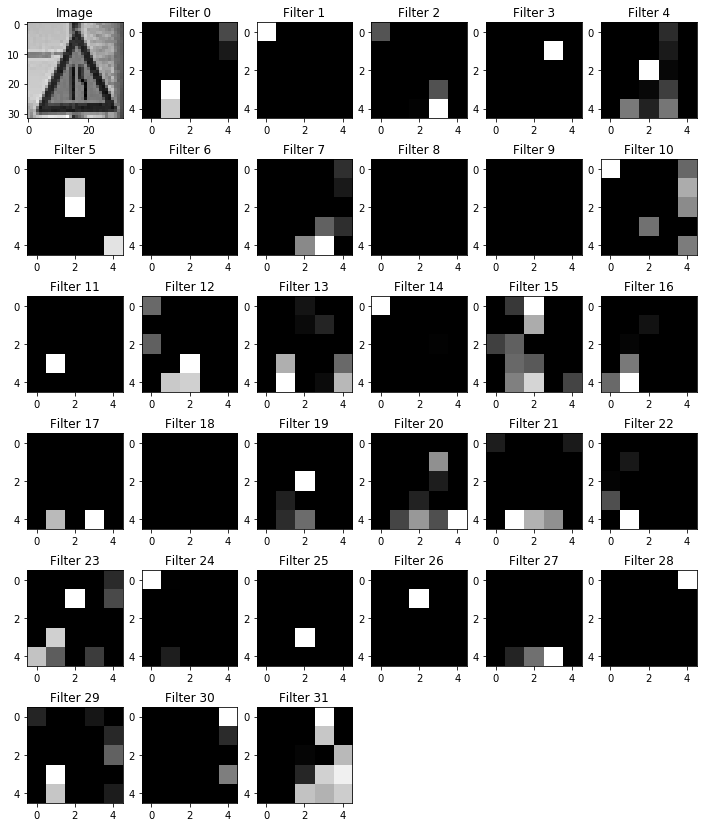

conv3_relu:


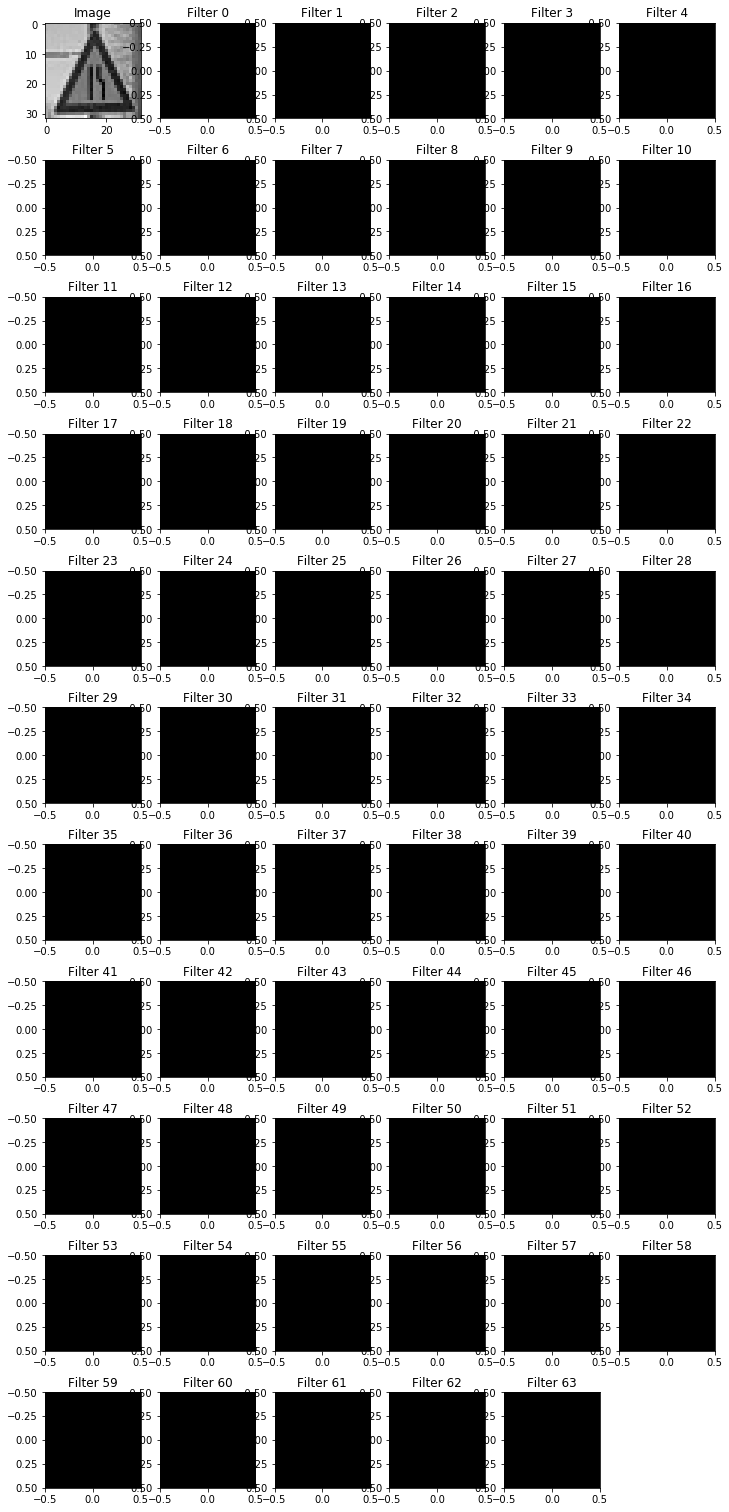

In [156]:
X = np.array([X_new[1]])
output_feature_map(X, 'conv1_relu')
output_feature_map(X, 'conv1_pool')
output_feature_map(X, 'conv2_relu')
output_feature_map(X, 'conv2_pool')
output_feature_map(X, 'conv3_relu')

conv1_relu:


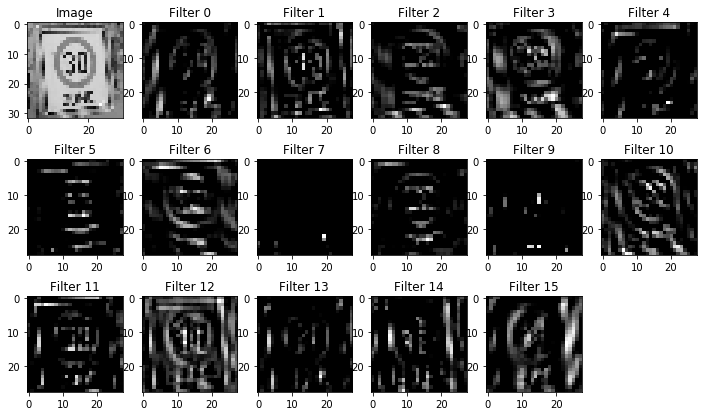

conv1_pool:


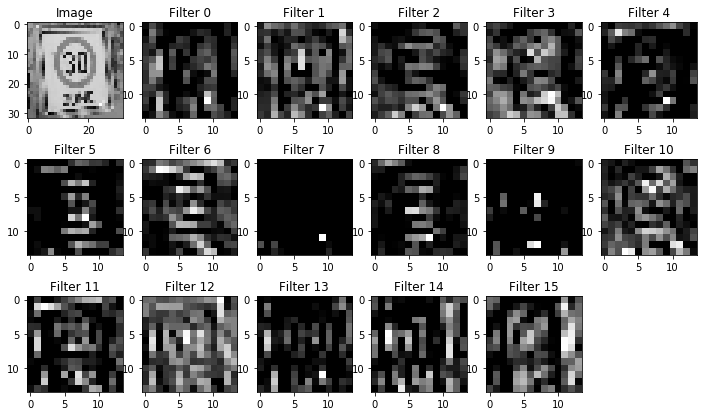

In [157]:
X = np.array([X_new[-1]])
output_feature_map(X, 'conv1_relu')
output_feature_map(X, 'conv1_pool')

conv1_relu:


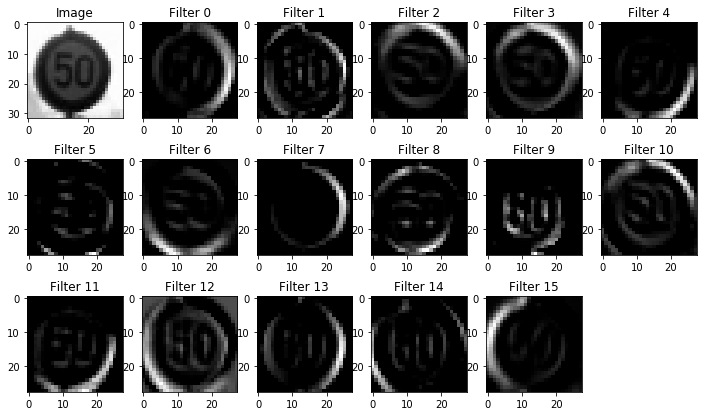

conv1_pool:


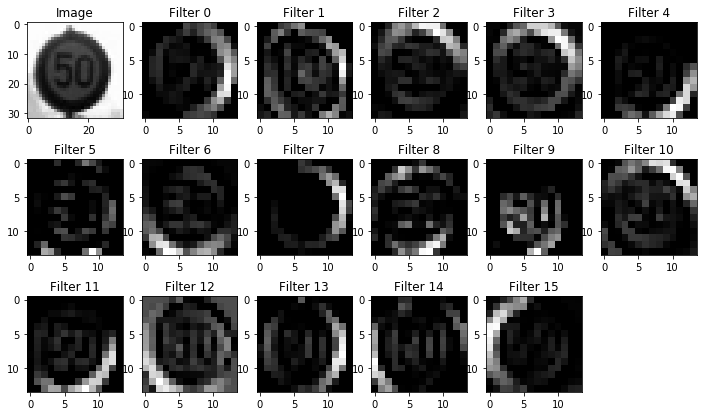

In [158]:
X = np.array([X_new[-4]])
output_feature_map(X, 'conv1_relu')
output_feature_map(X, 'conv1_pool')